In [20]:
import torch

In [21]:
# Enable gpu for training, validation and test if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
import torch.nn.functional as func
from torch.nn import Sequential, Linear, ReLU, ModuleList
from torch_geometric.nn import GINConv, BatchNorm, global_mean_pool

In [23]:
# GNN model definition
class ClusteringCoefficientGNN(torch.nn.Module):
    # Model architecture
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(ClusteringCoefficientGNN, self).__init__()

        # Initialize module lists
        self.convs = ModuleList()
        self.bns = ModuleList()
        
        # Input GIN layer
        self.convs.append(GINConv(
            Sequential(
                Linear(in_channels, hidden_channels[0]),
                ReLU(),
                Linear(hidden_channels[0], hidden_channels[0])
            ), train_eps=self.training
        ))
        self.bns.append(BatchNorm(hidden_channels[0]))
        
        # GIN layers (hidden layers)
        for i in range(num_layers - 1):
            self.convs.append(GINConv(
                Sequential(
                    Linear(hidden_channels[0] if i == 0 else hidden_channels[1], hidden_channels[1]),
                    ReLU(),
                    Linear(hidden_channels[1], hidden_channels[1])
                ), train_eps=self.training 
            ))

            self.bns.append(BatchNorm(hidden_channels[1]))
        
        # Output fully connected layer
        self.linear = Sequential(
            Linear(hidden_channels[1], hidden_channels[1]),
            ReLU(),
            Linear(hidden_channels[1], out_channels)
        )
        
        self.dropout = dropout

    # Forward pass (inference)
    def forward(self, x, edge_index, batch):
        # GIN layers
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = func.relu(x)
            x = func.dropout(x, p = self.dropout, training = self.training)

        # Global mean pool (graph-level features)
        x = global_mean_pool(x, batch)

        # Fully connected layer
        x = self.linear(x)
        x = func.relu(x)

        return x

In [24]:
# Evaluation function (for validation and test)
@torch.no_grad()
def evaluate(model, evaluation_data_loader, loss_function):
    # Set model to evaluation mode
    model.eval()
    evaluation_total_loss = 0

    # Evaluation over all graphs in evaluation_data_loader
    for data in evaluation_data_loader:
        # Move data to device (gpu if available)
        data = data.to(device)

        # Forward pass
        out = model(data.x, data.edge_index, data.batch)

        # Compute loss
        loss = loss_function(out.squeeze(dim=1), data.y)

        evaluation_total_loss += loss.item()

    return evaluation_total_loss / len(evaluation_data_loader) 

In [25]:
import matplotlib.pyplot as plt

In [26]:
# Number of node features
in_channels = 6

# Output dimension (regression task over scalar numbers)
out_channels = 1

# Hyperparameters for GNN
hidden_channels = [128, 64]

# Number of layers
num_layers = 5

# Training settings
num_epochs = 1000
patience = 100

# Learning rate settings
learning_rate = 0.001
scheduler_ratio = 0.1

# Dropout probability
dropout = 0.2

Test score: 0.1469


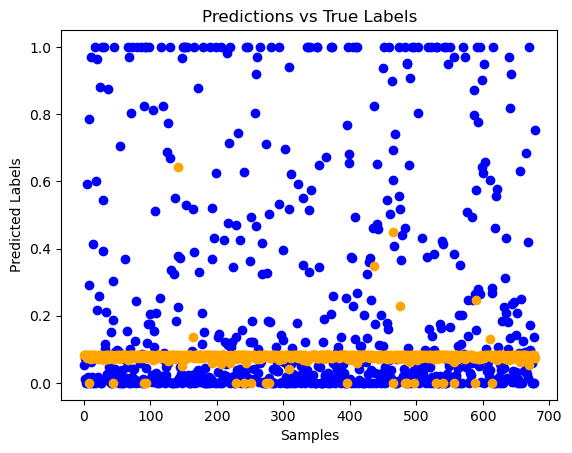

In [27]:
# Load model and set it in evaluation mode
model = ClusteringCoefficientGNN(in_channels, hidden_channels, out_channels, num_layers, dropout)
model.load_state_dict(torch.load("model/graph_gcc_net.pth", weights_only=True))
model.to(device)
model.eval()

# Load test DataLoader
test_data_loader = torch.load("datasets/test_data/test_dataloader.pt", weights_only=False)

# Test model
test_score = evaluate(model, test_data_loader, torch.nn.MSELoss())
print(f"Test score: {test_score:.4f}")

# Store predicitons and ground truths
predictions_list = []
ground_truth_list = []

torch.no_grad()
for data in test_data_loader:
    # Move data sample to GPU, if available
    data = data.to(device)

    # Evaluate sample using model
    out = model(data.x, data.edge_index, data.batch)

    # Append predictions and corresponding ground truth
    predictions_list.append(out.cpu())
    ground_truth_list.append(data.y.cpu())

# Concatenate batches both in predictions and ground truths lists
predictions_list = torch.cat(predictions_list).detach().numpy()
ground_truth_list = torch.cat(ground_truth_list).detach().numpy()

# Plot of ground truth vs model predictions
plt.scatter(range(len(ground_truth_list)), ground_truth_list, color='blue', label='Ground Truths')
plt.scatter(range(len(predictions_list)), predictions_list, color='orange', label='Predictions')
plt.xlabel("Samples")
plt.ylabel("Predicted Labels")
plt.title("Predictions vs True Labels")
plt.show()